In [9]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances


import sys
sys.path.append("../..")
from util.features import build_featureset
from util.author_vis import t_sne, pca
from util.clustering_eval import clustering_summary, print_clustering_classes

In [10]:
test_data = pd.read_pickle('../../data/04c_Test_Set.pkl')

# Prototype Featureset as Style Embedding

Goal: Model the style of committers by creating a self-built style embedding including features like length, polarity, and others that were explored earlier.

### Construct First Feature Set

A first feature set is set up with the length and the amount of point characters of a message to learn how to do the implementation.

In [11]:
import numpy as np

simple_feature_set = []

for message in test_data['message']:
    number_of_chars         = len(message)
    point_count             = message.count(".")
    simple_feature_set.append([number_of_chars, point_count])

simple_feature_set = np.array(simple_feature_set)

In [12]:
simple_feature_set

array([[275,   4],
       [ 89,   0],
       [131,   1],
       ...,
       [ 28,   0],
       [ 71,   0],
       [107,   0]])

### Construct Complex Feature Set

A second featureset containing more values is constructed by the corresponding function in features.py.

In [13]:
complex_featureset = build_featureset(test_data, normalize=False)

In [14]:
np.save('../../data/03a_Test_Set_Features', complex_featureset)

In [15]:
complex_featureset = np.load('../../data/03a_Test_Set_Features.npy', allow_pickle=True)

### Normalize

In [16]:
# vectors = simple_feature_set / np.linalg.norm(simple_feature_set)
vectors = complex_featureset / np.linalg.norm(complex_featureset)

## Centroids

In [17]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

100%|██████████| 7/7 [00:00<00:00, 2410.32it/s]


In [18]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,0,1,2,3,4,5,6
0,0.000,0.004,0.003,0.004,0.005,0.005,0.006
1,0.000,0.000,0.001,0.000,0.001,0.001,0.001
2,0.000,0.000,0.000,0.001,0.002,0.002,0.002
3,0.000,0.000,0.000,0.000,0.001,0.001,0.001
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

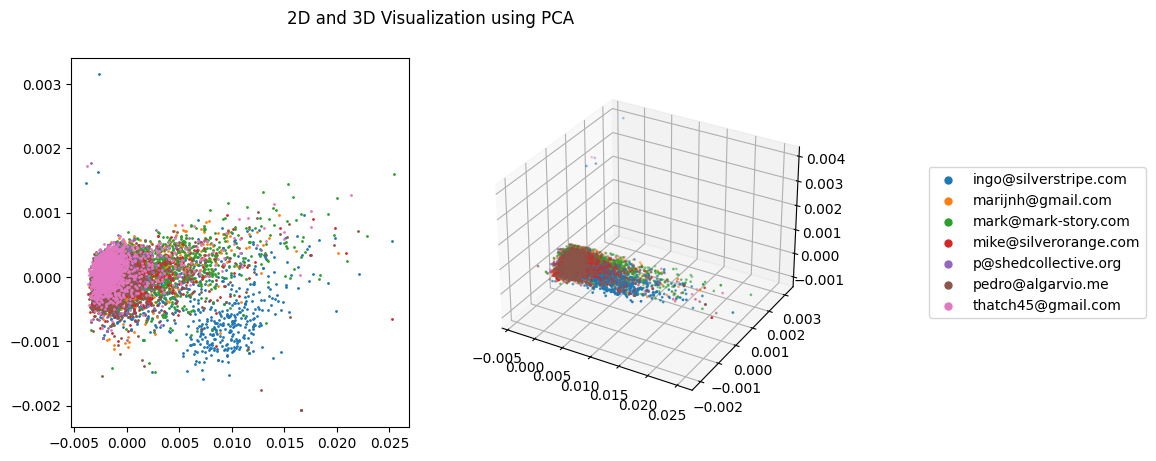

In [19]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

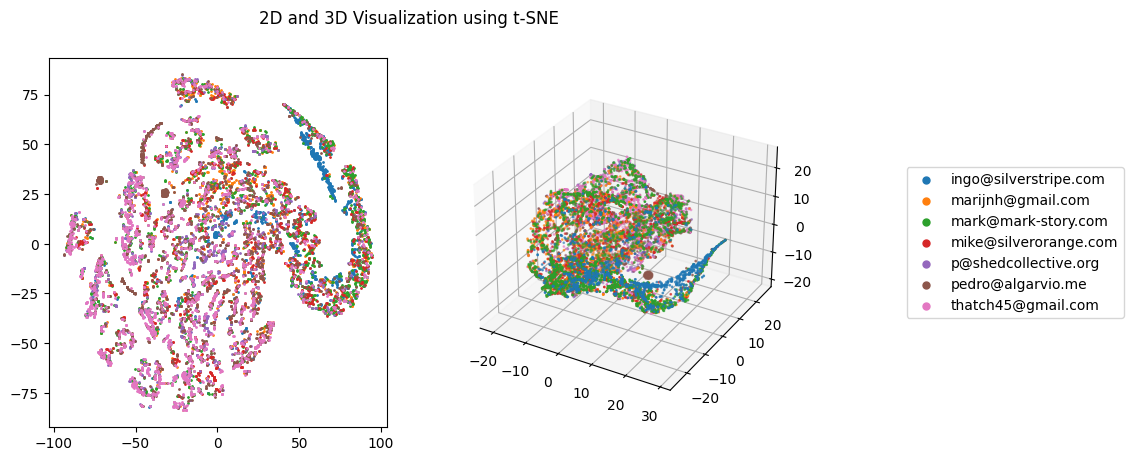

In [20]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data)

It can be seen that many SpaCy representations are similar and might be difficult to cluster. 

Anyways, below we try a density-based DBSCAN clustering and a centroid-based K-Means clustering to see if we can find clusters in the data.

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 1
10 Most common:
[(0, 10684)]


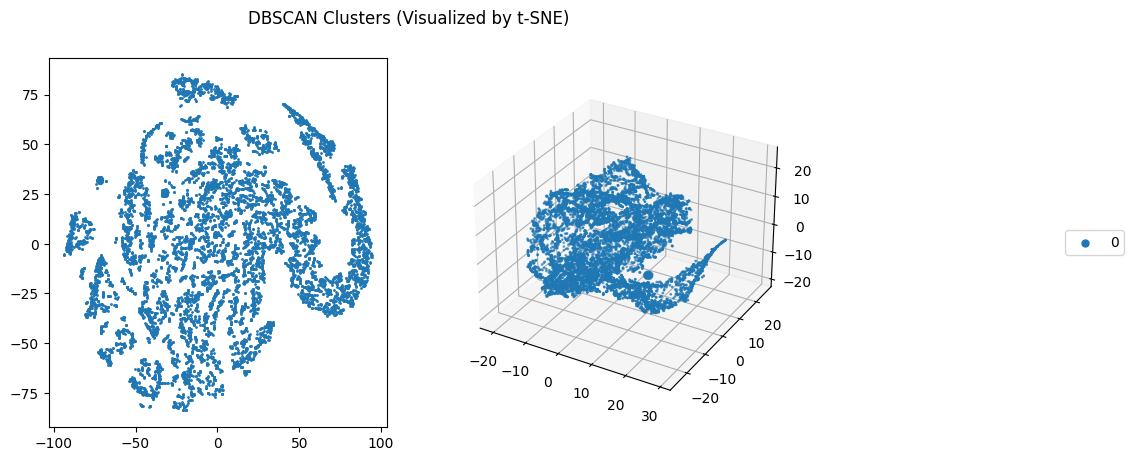

In [21]:
dbscan_model = DBSCAN(eps=2, min_samples=50)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [22]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,10684.0,7.0,1526.285714,"('mark@mark-story.com', 2082)",91.0,117.406593,"('saltstack_salt', 3798)"


In [23]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,1.0,1.0,1.000000,1.0,1.000000
mean,10684.0,7.0,1526.285714,91.0,117.406593
std,NaN,NaN,NaN,NaN,NaN
min,10684.0,7.0,1526.285714,91.0,117.406593
25%,10684.0,7.0,1526.285714,91.0,117.406593
50%,10684.0,7.0,1526.285714,91.0,117.406593
75%,10684.0,7.0,1526.285714,91.0,117.406593
max,10684.0,7.0,1526.285714,91.0,117.406593


In [24]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
API CHANGE Removed Member::init_db_fields(), its no longer needed due to the Member.PasswordEncyrption property changing from an ENUM to Varchar.

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
2) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
3) 
MINOR Protection against infinite initialization/callback loops caused by loading a full page template via ajax (in LeftAndMain.js)
___
4) 
Allowing success and error callbacks in refresh()
___
5) 
Better shell execution feedback from PDF extractor
___
6) 
BUGFIX: Make sure CMS link knows when its currently in the CMS (from r<I>)

git-svn-id: svn://svn.silverstripe.com/silverstripe/open/modules/sapphire/branches/<I>@<I> <I>b<I>ca-7a2a-<I>-9d3b-<I>d<I>a<I>a9
___
7) 
Added iShouldSeeAButton assertion
___
8) 
MINOR ArrayLib - removed unncessary extending of Objec

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

Number of Clusters: 7
10 Most common:
[(2, 3711), (5, 3627), (0, 1593), (6, 812), (4, 517), (1, 338), (3, 86)]


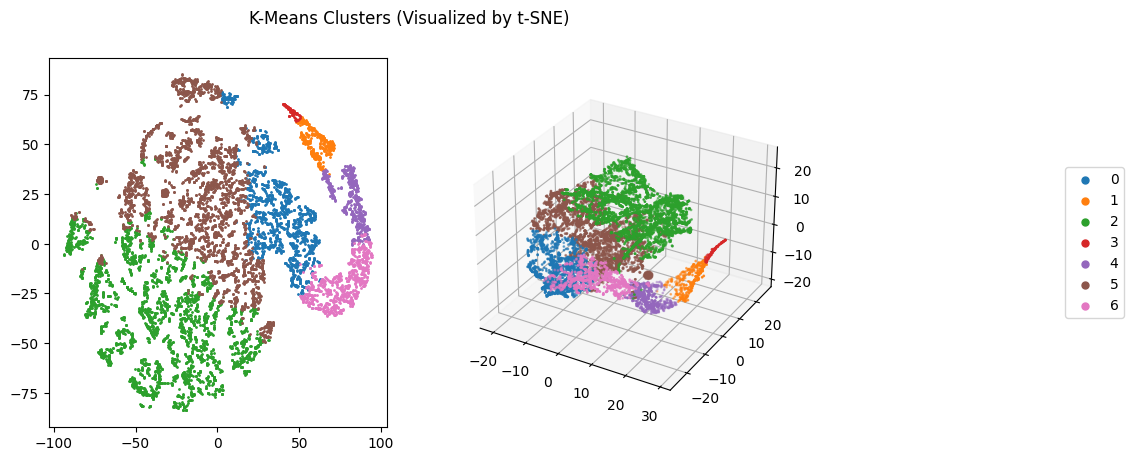

In [25]:
kmeans = KMeans(7)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [26]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 91 different projects.


,Number of Messages,Number of different Authors,Average number of commits per different Author,Most common Author,Number of different Projects,Average number of commits per different Project,Most common project
0,1593.0,7.0,227.571429,"('mark@mark-story.com', 369)",55.0,28.963636,"('cakephp_cakephp', 343)"
1,338.0,7.0,48.285714,"('ingo@silverstripe.com', 201)",20.0,16.900000,"('silverstripe_silverstripe-framework', 134)"
2,3711.0,7.0,530.142857,"('thatch45@gmail.com', 1114)",73.0,50.835616,"('saltstack_salt', 1808)"
3,86.0,6.0,14.333333,"('ingo@silverstripe.com', 33)",12.0,7.166667,"('cakephp_cakephp', 27)"
4,517.0,7.0,73.857143,"('ingo@silverstripe.com', 178)",33.0,15.666667,"('cakephp_cakephp', 163)"
5,3627.0,7.0,518.142857,"('pedro@algarvio.me', 853)",71.0,51.084507,"('saltstack_salt', 1468)"
6,812.0,7.0,116.000000,"('mark@mark-story.com', 295)",40.0,20.300000,"('cakephp_cakephp', 283)"


In [27]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Average number of commits per different Author,Number of different Projects,Average number of commits per different Project
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1526.285714,6.857143,218.333333,43.428571,27.273870
std,1538.708085,0.377964,219.497132,23.894610,17.417599
min,86.000000,6.000000,14.333333,12.000000,7.166667
25%,427.500000,7.000000,61.071429,26.500000,16.283333
50%,812.000000,7.000000,116.000000,40.000000,20.300000
75%,2610.000000,7.000000,372.857143,63.000000,39.899626
max,3711.000000,7.000000,530.142857,73.000000,51.084507


In [28]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Set omnipay response earlier in PurchaseService

It might be used in onCaptured callbacks
___
2) 
BUGFIX Always fall back to creating a new step (in case the session or request data is invalid)
___
3) 
BUGFIX Making HTML5 History support optional, so we can disable HTML4 hash change fallback
___
4) 
MINOR Only setting form state if form element is available in 'ss-ui-button'
___
5) 
Re-added 'auto' sizing for CMS preview

Regression from making sizes configurable via JS
___
6) 
Allow form action props override in FormBuilder

Also added bootstrapButtonStyle defaults
___
7) 
MINOR Exclude buttons from focusing first elements in CMS edit form, as it stuffs up the layout engine
___
8) 
MINOR Allowing array-based values in Diff->getHTMLChunks() by imploding on comma (AIR-<I>)
___
9) 
BUGFIX More solid checks in Subsite permission methods to deal with non-existing members
___
10) 
BUGFIX Don't show subsites drop down in ReportAdmin, as fil